# To-do: 
- Based on the above, we need to remove the names of the co-hosts from the list of words that show up! -- done
- string cleaning
- add a narrative around/context behind each of our analysis choices below
- double check the PMI calculations (does it make sense that they are all equal to one another?)


# Adjust stop words

In [2]:
from sklearn.feature_extraction import text 

#text.ENGLISH_STOP_WORDS

In [3]:
add_stop_words = ['anderson', 'cooper', 'rachel', 'maddow', 'cnn', 'msnbc']

In [4]:
full_stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

In [5]:
full_stop_words

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'anderson',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside

## Load in Data

### Read in the total list of data files

In [7]:
#import libraries
import glob 
import os
import matplotlib.pyplot as plt

#step 1: get a list of file names to read into the dataset
repo_path = os.path.dirname(os.getcwd()) #get the correct file path 
rm_paths = glob.glob(repo_path + "/data/01-raw/rachel_maddow/*.txt") #the paths for the rachel maddow transcript files
ac_paths = glob.glob(repo_path + "/data/01-raw/anderson_cooper/*.txt") #the paths for the anderson cooper transcript files

all_liberal_files = rm_paths + ac_paths


### Read in text of transcript files

In [8]:
raw_text = [] #create a container to hold the datafiles 

#step 2: read in each transcript as its own string and append to the list of raw documents
for transcript in all_liberal_files:
    text = open(transcript, encoding='utf-8').read()
    raw_text.append(text)


In [9]:
print("Our liberal news corpus consists of {:,} total transcripts, sourced from Anderson Cooper 360 and the Rachel Maddow Show.".format(len(raw_text)))

Our liberal news corpus consists of 1,008 total transcripts, sourced from Anderson Cooper 360 and the Rachel Maddow Show.


## Data Pre-Processing

### Spacy Implementation & Removal of Stop Words 
This analysis is useful if we want more control over the corpus of stop words that are used in our analysis

In [8]:
#Compare spacy implemtation to the sklearn #loads spacy and turns off some aspects 
# import spacy
# nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])


## Word- Frequency Analysis

### Use CountVectorizer to get the unique vocabulary list and eliminate stop words



In [10]:
#import the required package for the tfidf vector
from sklearn.feature_extraction.text import CountVectorizer

#step 1: set up the tfidf vectorizer
vectorizer = CountVectorizer(min_df = 50, 
                             stop_words = full_stop_words, 
                             max_df = 0.8) #update/justify using these settings 
 
#step 2: apply the vectorizer to the corpus of documents (& store in document matrix X )
X = vectorizer.fit(raw_text) #should we use just .fit or .fit_transform? The latter actually results in the creation of a matrix object (where # of cols = # of words in the vocab)

#step 3: print out the vocabulary found by the tfid object
print("There are {:,} unique words in the vocabulary.".format(len(X.vocabulary_)))

There are 4,986 unique words in the vocabulary.


In [11]:
#check to see if "covid" is in the dictionary
vocab = X.vocabulary_

#vocab['covid'] #results in an index of 1197) 
#Note: this is NOT equivalent to the number of times covid appears in the documents
# the number below is solely an index value

In [12]:
#check to see if "coronavirus" is in the dictionary - return index

vocab['coronavirus']

1095

### Get a Word-Frequency Table from CountVectorizer
   Note: need to double-check how the counts are arrived at - is it by document or number of occurences in a given document?

In [13]:
X_transformed = vectorizer.fit_transform(raw_text)


In [14]:
array_of_words = vectorizer.get_feature_names_out()
array_of_words

array(['00', '01', '02', ..., 'zero', 'zone', 'zoom'], dtype=object)

In [15]:
array_of_counts = X_transformed.toarray().sum(axis=0) #sum the number of occurences of a word across the entire liberal corpus
array_of_counts

array([3500,  413,  396, ...,  483,  190,   81])

In [16]:
word_frequency_dictionary = dict(zip(array_of_words,array_of_counts))

### Plot the Top 10 Most Frequency Occuring Words

In [17]:
from operator import itemgetter

#set the number of top words to see
num_top_words = 10

top_10_words = dict(sorted(word_frequency_dictionary.items(), key = itemgetter(1), reverse = True)[:num_top_words])

print(top_10_words)


{'republicans': 6014, 'dr': 5812, 'police': 5547, 'health': 5397, 'court': 5303, 'vote': 5294, 'justice': 5266, 'vaccine': 5111, 'department': 5027, 'voice': 5019}


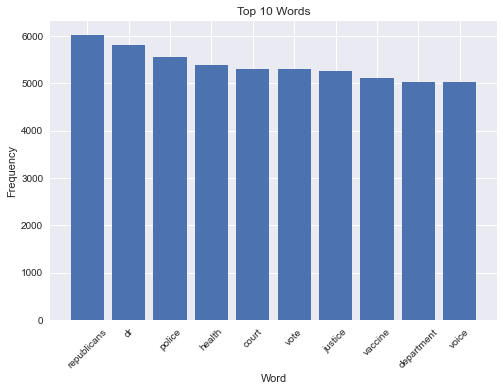

In [76]:
plt.style.use('seaborn')  

x = top_10_words.keys()
y = top_10_words.values()
plt.bar(x,y)
plt.xlabel('Word')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Top 10 Words')

plt.show()

In [18]:
# total_unique_words = X.vocabulary_ #, key=lambda d: d[1]) 

# total_unique_words
#X.vocabulary_

## Co-Occurence Analysis

- Need to do string cleaning. 
- For now, appearance anywhere in a transcript increases count by 1.
- it might make sense to do this with the count vectorizer from above?

In [20]:
# import packages
from collections import Counter
import spacy
import numpy as np

In [21]:
# instantiate nlp
nlp = spacy.load('en_core_web_sm', disable = ['parser'])

In [22]:
# need to do some pre-processing/string cleaning*****
# warning: takes a while -- approximately: 27 to 30 minutes
liberal_nlp = [nlp(text) for text in raw_text]

In [23]:
# num transcripts
num_transcripts = len(liberal_nlp)

In [24]:
# see full lemma set - identify how covid is named
lemma_set = set(token.lemma_.lower() for transcript in liberal_nlp for token in transcript)
len(lemma_set)

56824

In [25]:
# covid_terms
covid_terms = ['coronavirus', 'covid', 'covid-19']

lemma_set.intersection(set(covid_terms))

{'coronavirus', 'covid', 'covid-19'}

In [26]:
# counters
lemma_counts = Counter()
co_occur_counts = Counter()
covid_count = 0

# for each transcript, add unique lemmas to counter
# increase co-occurrence and covid counter if covid terms overlap lemma set
for transcript in liberal_nlp:
    lemmas = {token.lemma_.lower() for token in transcript}
    lemma_counts.update(lemmas)
    if not lemmas.isdisjoint(set(covid_terms)):
        co_occur_counts.update(lemmas)
        covid_count += 1

# P(covid)
covid_ratio = covid_count / num_transcripts # constant

# calculate PMI only for words that co-occur (do not care about others)
pmi = list()
for lemma, count in co_occur_counts.items():
    
    lemma_ratio = lemma_counts[lemma] / num_transcripts # P(lemma)
    co_ratio = co_occur_counts[lemma] / num_transcripts # P(covid, lemma)
    
    pmi += [(lemma, 
             np.log2(co_ratio / (covid_ratio * lemma_ratio)))]

# sort list of tuples by pmi, descending
pmi_sort = sorted(pmi, key = lambda x: x[1], reverse = True)

In [27]:
# see top 100 pmi values (note ties)
pmi_sort[0:100]

[('merkel', 0.21240833276382595),
 ('singer', 0.21240833276382595),
 ('lizard', 0.21240833276382595),
 ('jbs', 0.21240833276382595),
 ('ahead.(commercial', 0.21240833276382595),
 ('traveler', 0.21240833276382595),
 ('9th', 0.21240833276382595),
 ('collaborative', 0.21240833276382595),
 ('cdc`s', 0.21240833276382595),
 ('azar', 0.21240833276382595),
 ('ppe', 0.21240833276382595),
 ('epidemiological', 0.21240833276382595),
 ('announcer', 0.21240833276382595),
 ('inmate', 0.21240833276382595),
 ('blower', 0.21240833276382595),
 ('californians', 0.21240833276382595),
 ('coronavirus', 0.21240833276382595),
 ('vent', 0.21240833276382595),
 ('2,700', 0.21240833276382595),
 ('errand', 0.21240833276382595),
 ('metaphor', 0.21240833276382595),
 ('institutes', 0.21240833276382595),
 ('indoor', 0.21240833276382595),
 ('stabilize', 0.21240833276382595),
 ('anesthesia', 0.21240833276382595),
 ('bedminster', 0.21240833276382595),
 ('tampa', 0.21240833276382595),
 ('wuhan', 0.21240833276382595),
 ('to

## Topic Modeling
* need to do string cleaning, remove host names, etc.
* maybe remove all named entities?
* (Added by Tobi) -- maybe we could also do some analysis like in Lecture 9 to find "Coherent" topics to help us select a better value for k (or num_topics)

In [28]:
num_topics = 10

import numpy as np
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components = num_topics, 
                                random_state = 0)

lda.fit(X_transformed)

LatentDirichletAllocation(random_state=0)

In [38]:
# shape
lda.components_.shape

(10, 4986)

In [39]:
# normalize to get probability distributions
topic_word_dist = np.array([row / row.sum() for row in lda.components_])

topic_word_dist.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [40]:
# list top 20 words in each topic
for topic_idx in range(num_topics):
    print('\n', 'Topic ', topic_idx, ':', sep = '')
    sort_idx = np.argsort(-topic_word_dist[topic_idx])
    for rank in range(20):
        word_idx = sort_idx[rank]
        print('{:<80} {:<10}'.format(array_of_words[word_idx], topic_word_dist[topic_idx, word_idx]))


Topic 0:
capitol                                                                          0.011621434013400732
january                                                                          0.009765252643516185
committee                                                                        0.0066977433474271954
republicans                                                                      0.006592829915933665
party                                                                            0.006389496274723441
senate                                                                           0.005791554476852593
6th                                                                              0.005037030058410929
attack                                                                           0.004794737446354583
pence                                                                            0.004658730885280417
congress                                                               

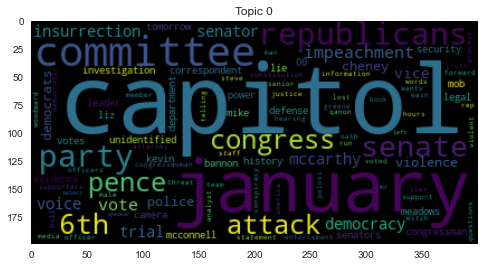

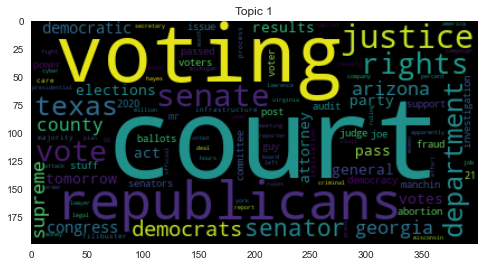

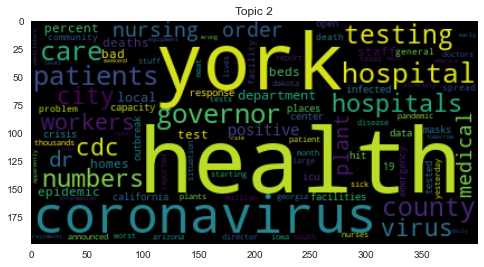

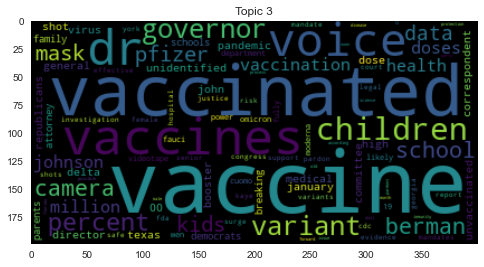

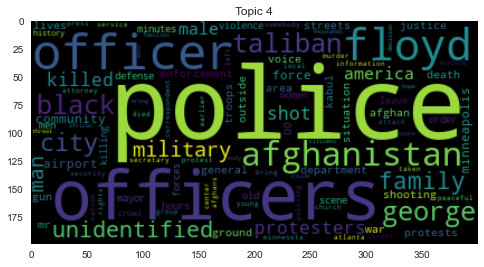

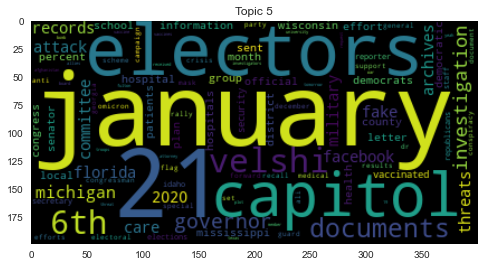

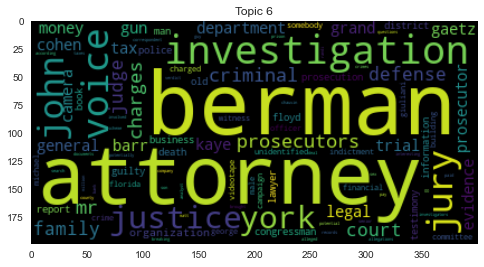

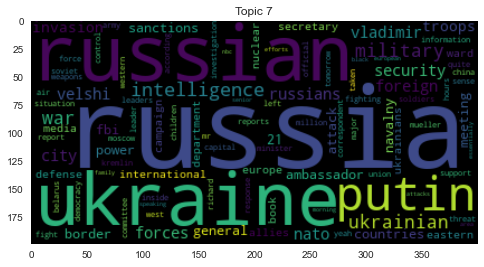

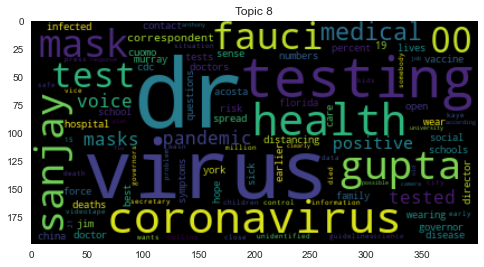

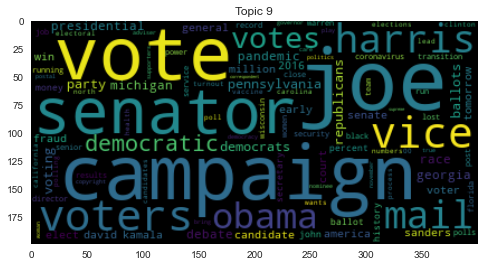

In [42]:
from wordcloud import WordCloud

for topic_idx in range(num_topics):
    wc = WordCloud(max_words = 100)
    wc.generate_from_frequencies(dict(zip(array_of_words, topic_word_dist[topic_idx])))
    plt.figure()
    plt.imshow(wc, interpolation = 'bilinear')
    plt.title('Topic %d' % topic_idx)
    plt.grid(visible = None)

Ideas:
1. We're really focused on **co-occurrences** with words like vaccines, covid etc. It could be helpful to try to use the results from LDA to extract just the topics related to covid and see what the co-occurring words are for those topics?

## Sentiment Analysis

pmi -- (lemma, co-occurence)
Should we just look at the sentiment of the co-occuring words?

Soruce for sentiment analysis work = 
Need to use the raw_text, string of strings for this analysis

Keep in mind that VADER is likely better at rating tweets than it is at rating long movie reviews. To get better results, you’ll set up VADER to rate individual sentences within the review rather than the entire text.

Will use the VADER method = NLTK already has a built-in, pretrained sentiment analyzer called VADER (Valence Aware Dictionary and sEntiment Reasoner).

Source: https://realpython.com/python-nltk-sentiment-analysis/

### Step 1: Convert List of 1 String Per Transcript to A List of Strings of **All of the Sentences** In the Dataset

Here we split each of the text files on "." - which we are using to incidate different sentences

In [50]:
transcript_sentences = [text.split(".") for text in raw_text]

#collapse the sentences togehter so instead of a list of lists (with each sublist = 1 transcript, we get all of the sentences across all of the transcripts)
flattened_transcripts_sentences = [sentence for single_transcript in transcript_sentences for sentence in single_transcript]


print( "There are {:,} sentences acrosss the {:,} transcripts in the liberal corpus.".format(len(flattened_transcripts_sentences), len(transcript_sentences)))

There are 459,365 sentences acrosss the 1,008 transcripts in the liberal corpus.


### Step 2: Subset the List of Sentences That Include COVID Terms + The Top 100 Co-Occcurring Words

The goal here is to better understand the context/sentiment around how covid is discussed in the liberal corpus. 

In [53]:
# top_100_pmi_words = pmi_sort[:100]

# top_100_pmi_words_dict = dict(top_100_pmi_words)

# total_covid_words = covid_terms + list(top_100_pmi_words_dict.keys())

# print(total_covid_words)



#For now, until we can do some better string cleaning, I will just be including covid-terms
covid_sentences = [sentence for sentence in flattened_transcripts_sentences if any(word in sentence for word in covid_terms)]

print("There are {:,} sentences across the corpus that mention one of the covid-related terms.".format(len(covid_sentences)))


There are 3,224 sentences across the corpus that mention one of the covid-related terms.


### Step 3: Determine the Sentiment of Each of the Sentences


In [57]:
#to run the code chunk below, you may need to run the following lines:
#import nltk
# import ssl

# try: #attempt to address SSL issues that come up
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context 

#nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/tobijegede/nltk_data...


True

In [58]:
#import the required packages
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()


In [59]:
#test the package
sia.polarity_scores("Wow, NLTK is really powerful!")

{'neg': 0.0, 'neu': 0.295, 'pos': 0.705, 'compound': 0.8012}

In [80]:
#try the sentiment analysis on the covid_sentences

#store all of the compound scores
total_compound_scores = []
positive_setences = []
negative_sentences = []
neutral_sentences = []
#first 5 sentences test
for sentence in covid_sentences:
    score = sia.polarity_scores(sentence)
    compound_score = score["compound"]
    total_compound_scores.append(compound_score)

    if compound_score == 0:
        neutral_sentences.append((sentence, score))
    elif compound_score > 0:
        positive_setences.append((sentence, score))
    else: 
        negative_sentences.append((sentence, score))

print("The mean compound sentiment score is: {}".format(sum(total_compound_scores)/len(total_compound_scores)))
print("There are {:,} positive sentences, {:,} neutral sentences, {:,} and negative sentences.".format(len(positive_setences), len(neutral_sentences), len(negative_sentences)))

The mean compound sentiment score is: -0.0014219292803969955
There are 1,182 positive sentences, 939 neutral sentences, 1,103 and negative sentences.


## Plot the Sentiment Distribution

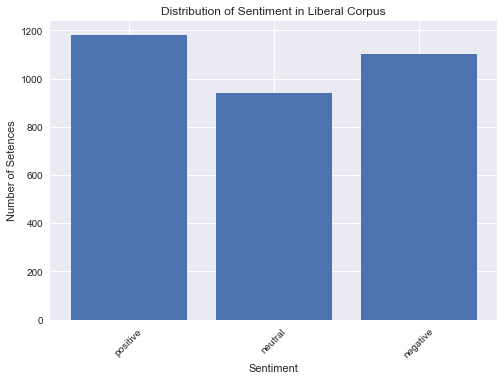

In [78]:
plt.style.use('seaborn')  

x = ["positive", "neutral", "negative"]
y = [len(positive_setences), len(neutral_sentences), len(negative_sentences)]
plt.bar(x,y)
plt.xlabel('Sentiment')
plt.xticks(rotation=45)
plt.ylabel('Number of Setences')
plt.title('Distribution of Sentiment in Liberal Corpus')

plt.show()

### Top 10 Positive Sentences


In [92]:
positive_sentences_sort = sorted(positive_setences, key = lambda x: x[1]["pos"], reverse = True)


top_10_positive_sentences = positive_sentences_sort[:10]

for idx, combo in enumerate(top_10_positive_sentences):
    sentence, score = combo #deconstruct the sentence, score combo
    print("{}. {} \n Percent Positive: {:.1%} \n Percent Neutral: {:.1%} \n Percent Negative: {:.1%} \n".format(idx+1, sentence, score["pos"], score["neu"], score["neg"]))



1.  tested positive for coronavirus 
 Percent Positive: 54.5% 
 Percent Neutral: 45.5% 
 Percent Negative: 0.0% 

2.  Trump aide Hope Hicks tested positive for coronavirus 
 Percent Positive: 52.0% 
 Percent Neutral: 48.0% 
 Percent Negative: 0.0% 

3.  Barnabas, fighting coronavirus like all doctors a health care worker like all health care workers are trying to keep coronavirus patients alive 
 Percent Positive: 44.4% 
 Percent Neutral: 47.6% 
 Percent Negative: 7.9% 

4.  The president of the United States testing positive for coronavirus 
 Percent Positive: 44.4% 
 Percent Neutral: 55.6% 
 Percent Negative: 0.0% 

5.  Quote, Trump and friends got coronavirus care many others couldn't 
 Percent Positive: 44.1% 
 Percent Neutral: 55.9% 
 Percent Negative: 0.0% 

6.  Seven-time NASCAR Cup Series champion Jimmie Johnson has tested positive for coronavirus 
 Percent Positive: 42.9% 
 Percent Neutral: 57.1% 
 Percent Negative: 0.0% 

7.  staff have tested positive for coronavirus 
 Perce

## Top 10 Negative Sentences

In [93]:
negative_sentences_sort = sorted(negative_sentences, key = lambda x: x[1]["neg"], reverse = True)


top_10_negative_sentences = negative_sentences_sort[:10]

for idx, combo in enumerate(top_10_negative_sentences):
    sentence, score = combo #deconstruct the sentence, score combo
    print("{}. {} \n Percent Negative: {:.1%}  \n Percent Neutral: {:.1%} \n  Percent Positive: {:.1%}\n".format(idx+1, sentence, score["neg"], score["neu"], score["pos"]))


1. And, unfortunately, he lost his battle to the coronavirus 
 Percent Negative: 54.9%  
 Percent Neutral: 45.1% 
  Percent Positive: 0.0%

2.  You criticized President Trump's response to the coronavirus crisis 
 Percent Negative: 48.5%  
 Percent Neutral: 51.5% 
  Percent Positive: 0.0%

3. Hell, they`re not even giving them individualized guidance on how to fight coronavirus 
 Percent Negative: 48.0%  
 Percent Neutral: 52.0% 
  Percent Positive: 0.0%

4.  War number one is coronavirus 
 Percent Negative: 47.6%  
 Percent Neutral: 36.6% 
  Percent Positive: 15.9%

5.  She beat the 1918 flu, cancer and now the coronavirus 
 Percent Negative: 46.7%  
 Percent Neutral: 53.3% 
  Percent Positive: 0.0%

6.  Yesterday, Wednesday, the prison reported that a second prisoner had died from coronavirus at that facility 
 Percent Negative: 46.4%  
 Percent Neutral: 53.6% 
  Percent Positive: 0.0%

7.   UNIDENTIFIED FEMALE: The risk of the coronavirus is a scam 
 Percent Negative: 45.3%  
 Perce

To-do :
* could do some additional work/topic LDA analysis on the negative/positive sentences to see how, even if the sentiment is negative, the nature of the negative 
* sentiment is different across conservative versus liberal corpuses

#### Examine How Vaccinations Are Generally Talked About
- perhaps we also do some PMI analysis with the word "vaccine" and "masks" as well

In [63]:
vaccine_terms = ["vaccine", "jab", "vaccinations", "vaccination", "moderna", "pfizer", "j&j", "johnson&johnson"]
vaccine_sentences = [sentence for sentence in flattened_transcripts_sentences if any(word in sentence for word in vaccine_terms)]

print("There are {} sentences in the {} transcripts about vaccines.".format(len(vaccine_sentences), len(transcript_sentences)))

There are 6902 sentences in the 1008 transcripts about vaccines.
